## We have developed a demonstration of the LBN-MOBO algorithm applied to the ZDT3 problem (30 dimensions). The code is designed to be easily adaptable to different datasets.

Create a new directory with the name **lbn_mobo-main** and transfer the project in that folder. Connect the colab to your google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the directory to the project directory.

In [3]:
import os
os.chdir('/content/drive/MyDrive/lbn_mobo-main')
cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/lbn_mobo-main


Install the missing libraries. 

In [4]:
!pip install -U pymoo
!pip install pygmo
!pip install Platypus-Opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=432433d02409c9b61111662e9f9a3f4cd43271ec316a78f56c8712ea6f3763b3
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 74.9 MB/s 

Run **LBN-MOBO**. **Note** that here the deep ensemble models are trained sequentially while in reality they are run in parallel on multiple GPUs.

In [5]:
from Random_dataset_gen import random_dset_gen
from BO_surrogate_function_uncertainty import BO_surrogate_uncertainty
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from query_oracle import Oracle_function
import scipy.io as sio
import numpy as np
import os
import subprocess
import time
from acquisition_organizeer import dset_organizer
from Forward_BNN import BNN_diverse_func
from Acquisition_4_D import calculate_pareto_4_D

# Each iteration of NSGA-II is set to generate 1000 samples as a result choose a multiplication of 1000 as batch size (2000, 3000, ...).
Batch_size = 1000
iter_max = 5
problem_name = "zdt3"
# Generate the initial random data
dset = random_dset_gen(problem_name, Batch_size)
sio.savemat('Dataset/dset_0.mat', {'dset': dset})

data_folder = 'surrogate_pareto/with_uncertainty/'
elapsed_times = [] 
for n_iter in range(iter_max):
    start_time = time.time()
    # # Train the BNN
    #make the path for the models
    new_dir = 'Models/iter_%d' %(n_iter)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
        print("Directory created:", new_dir)
    else:
        print("Directory already exists:", new_dir)
    # BNN model training
    print('Training the models ...')
    for n_net in range(10):
      BNN_diverse_func(n_net, n_iter)
    dir_path = 'Models/iter_%d' %(n_iter)
    while True:
        # Get the number of files in the directory
        num_files = (len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

        # If there are 10 files, break out of the loop
        if num_files == 10:
            break
        # If there are less than 10 files, wait for 1 second and try again
        time.sleep(1)


    # Acquisition
    print('Running acquisition ...')
        # make the path for the acquisition
    new_dir = 'Acquisition/iter_%d' % (n_iter)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
        print("Directory created:", new_dir)
    else:
        print("Directory already exists:", new_dir)
    # Run acquisitions n=(Batch_size/1000) times. Each time it generates different 1000 samples
    for NSGA2_seed in range(int(Batch_size/1000)):
      calculate_pareto_4_D(n_iter, NSGA2_seed)
    dir_path_acquisition = 'Acquisition/iter_%d' %(n_iter)
    while True:
        # Get the number of files in the directory
        num_files = (len([entry for entry in os.listdir(dir_path_acquisition) if os.path.isfile(os.path.join(dir_path_acquisition, entry))]))
        # If there are n=(Batch_size/1000) files, break out of the loop
        if num_files ==  int(Batch_size/1000):
            break
        # If there are less than n=(Batch_size/1000) files, wait for 1 second and try again
        time.sleep(1)

    dset_new = dset_organizer(n_iter, int(Batch_size/1000))

    # Stack the newly generated candidates into the dataset
    mat = sio.loadmat('Dataset/dset_%d.mat' %(n_iter))
    mat = mat['dset']
    dset = mat[0][0]


    dset['X'] = np.concatenate((dset['X'], dset_new['X']))
    dset['Y'] = np.concatenate((dset['Y'], dset_new['Y']))
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    sio.savemat('Dataset/dset_%d.mat' %(n_iter+1), {'dset': dset})

elapsed_times_arr = np.array(elapsed_times)
output_filename = "execution_times.mat"  # Output .mat file name
sio.savemat(output_filename, {'elapsed_times': elapsed_times_arr})


Streaming output truncated to the last 5000 lines.
Epoch [56/60], Step [300/360], Loss: 1.9098
Validataion MSE is: 0.10963394492864609
Epoch [57/60], Step [100/360], Loss: 1.6041
Epoch [57/60], Step [200/360], Loss: 0.8418
Epoch [57/60], Step [300/360], Loss: 1.9091
Validataion MSE is: 0.10960251837968826
Epoch [58/60], Step [100/360], Loss: 1.5997
Epoch [58/60], Step [200/360], Loss: 0.8404
Epoch [58/60], Step [300/360], Loss: 1.9081
Validataion MSE is: 0.10956966131925583
Epoch [59/60], Step [100/360], Loss: 1.5965
Epoch [59/60], Step [200/360], Loss: 0.8391
Epoch [59/60], Step [300/360], Loss: 1.9073
Validataion MSE is: 0.1095399409532547
Epoch [60/60], Step [100/360], Loss: 1.5936
Epoch [60/60], Step [200/360], Loss: 0.8379
Epoch [60/60], Step [300/360], Loss: 1.9063
Validataion MSE is: 0.10950823128223419
2
Using device: cpu
13452
Epoch [1/60], Step [100/360], Loss: 11.9456
Epoch [1/60], Step [200/360], Loss: 3.1614
Epoch [1/60], Step [300/360], Loss: 3.4518
Validataion MSE is: 0.

Visualize the progression of hypervolume for various optimization algorithms. Please note that due to the computationally intensive nature of USeMO, TSEMO, and DGEMO algorithms, we are providing pre-computed data for the purpose of comparison (Figure 3 in the paper). Any slight variations observed are a result of using different algorithms to calculate the hypervolume in Python.

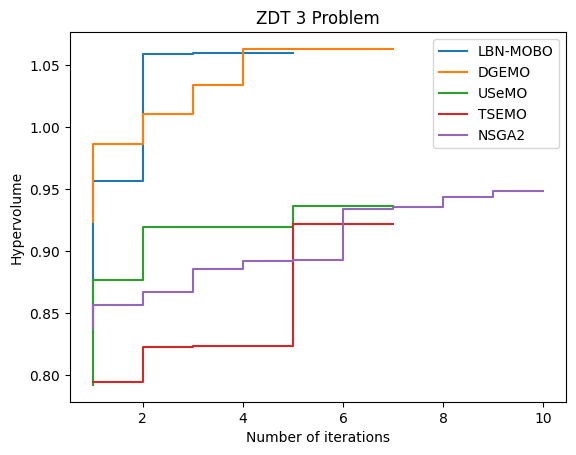

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload 
import hv_calculator
hv_calculator_ = reload(hv_calculator)


hyper_val_LBN_MOBO, ParetoFront_LBN_MOBO = hv_calculator_.hv_ploter(iter_max, './surrogate_pareto/ParetoFront_%d.mat', 0)
hyper_val_DGEMO, _ = hv_calculator_.hv_ploter(7, './DGEMO_data/DGEMO_pareto_iter_%d.mat', 1)
hyper_val_USeMO, _  = hv_calculator_.hv_ploter(7, './USeMO_data/USEMO_pareto_iter_%d.mat', 1)
hyper_val_TSEMO, _  = hv_calculator_.hv_ploter(7, './TSEMO_data/TSEMO_pareto_iter_%d.mat', 1)
hyper_val_NSGA2, _  = hv_calculator_.hv_ploter(10, './NSGA2_data/NSGA2_pareto_iter_%d.mat', 1)



# Plot the hyper volume of LBN-MOBO
plt.step(np.arange(1,iter_max+1), hyper_val_LBN_MOBO)
plt.step(np.arange(1,8), hyper_val_DGEMO)
plt.step(np.arange(1,8), hyper_val_USeMO)
plt.step(np.arange(1,8), hyper_val_TSEMO)
plt.step(np.arange(1,11), hyper_val_NSGA2)

# Customize the plot
plt.xlabel('Number of iterations')
plt.ylabel('Hypervolume')
plt.title('ZDT 3 Problem')
plt.legend(['LBN-MOBO', 'DGEMO', 'USeMO', 'TSEMO', 'NSGA2'])

# Show the plot
plt.show()

Plot the final paretofront after 10 iterations.

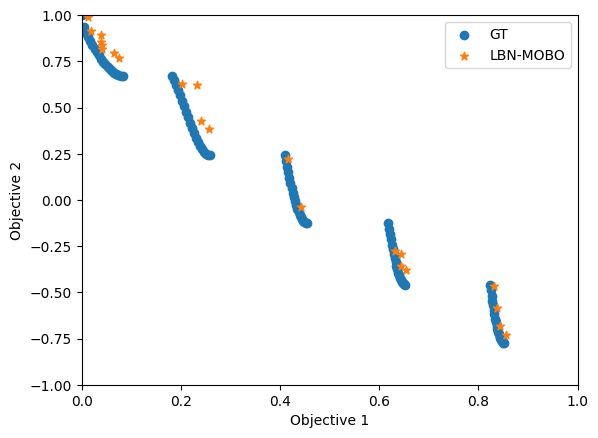

In [8]:
import scipy.io as sio

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    # Load and plot the GT
    mat = sio.loadmat('GT_data.mat')
    ParetoFront = mat['GT_data']
    plt.scatter(ParetoFront[:,0], ParetoFront[:,1])
    # plt.scatter(-Xs, -Ys, c='red')
    pf_X = [-pair[0] for pair in pareto_front]
    pf_Y = [-pair[1] for pair in pareto_front]
    plt.scatter(pf_X, pf_Y, marker='*')
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.legend(['GT', 'LBN-MOBO'])

    
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.show()


plot_pareto_frontier(-ParetoFront_LBN_MOBO[:,0], -ParetoFront_LBN_MOBO[:,1], maxX=True, maxY=True)